# Housing Regression Maching Learning Project

### Imports (Data and Packages)

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from data_preprocessing_final import cleaning, dummify_func
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline 

In [125]:
housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
housing = housing[housing['SaleCondition'] == 'Normal']
real_estate = pd.read_csv('./data/Ames_Real_Estate_data.csv' , index_col = 0)

C:\Users\jackc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (36,40,81,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [126]:
housing = cleaning(housing)
input, target = dummify_func(housing)

### EDA

<AxesSubplot:>

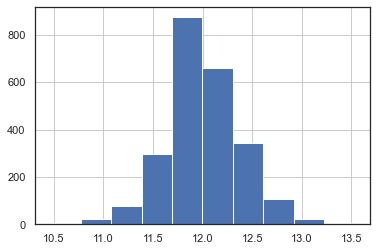

In [31]:
## First looking at Sale Price to see the features
np.log(housing['SalePrice']).hist()

## Histogram looks skewed right - is this going to be a problem? Maybe try a boxcox transformation or log? 

In [40]:
## See correlations related to sale price and to eyeball which features might matter the most 
corrs = housing.corr()
highly_correlated = corrs[np.abs(corrs['SalePrice']) >= .6]
medium_correlated = corrs[np.abs(corrs['SalePrice']).between(.4,.6)] 
low_correlated = corrs[(np.abs(corrs['SalePrice']) < .4)] 

## Print out column headers that are going to have high and medium correlations to sales price 
print('Highly correlated variables are: ')
print(highly_correlated['SalePrice'])
print('-'*150)
print('Medium correlated variables are: ')
print(medium_correlated['SalePrice'])
print('-'*150)
print('Low correlated variables are: ')
print(low_correlated['SalePrice'])

Highly correlated variables are: 
GrLivArea      0.736040
SalePrice      1.000000
OverallQual    0.787266
TotalBsmtSF    0.642555
1stFlrSF       0.634755
GarageCars     0.632217
GarageArea     0.621855
Name: SalePrice, dtype: float64
------------------------------------------------------------------------------------------------------------------------------------------------------
Medium correlated variables are: 
YearBuilt       0.533163
YearRemodAdd    0.501543
MasVnrArea      0.486528
BsmtFinSF1      0.454164
FullBath        0.548532
TotRmsAbvGrd    0.496571
Fireplaces      0.493448
Name: SalePrice, dtype: float64
------------------------------------------------------------------------------------------------------------------------------------------------------
Low correlated variables are: 
PID             -0.207391
MSSubClass      -0.075707
LotFrontage      0.344709
LotArea          0.275087
OverallCond     -0.091298
BsmtFinSF2       0.038297
BsmtUnfSF        0.159640
2ndFlrSF  

### Start dummifying variables and look at multicollinearity

In [62]:
## Identify Categorical Variables and create a list of them (With PID included so we can use as key later on)
category_list = list(housing.select_dtypes('object').columns)
category_list.append('PID')

## Use the list above to create a dataframe with just the categorical variables and PID
category_variables = housing[housing.columns.intersection(category_list)]

## Dummify the categorical variables
category = pd.get_dummies(data = category_variables, prefix_sep = '_' , drop_first=True)

## Remove the original categorical values from the dataframe and merge the dummified and original values into a new dataframe called final
housing.drop(columns = housing.select_dtypes('object').columns, axis =1, inplace=True)
final = pd.merge(housing, category, on = 'PID')


In [63]:
#Messing around with regression just to see

from sklearn.linear_model import LinearRegression

target = housing['SalePrice']
housing.drop(['SalePrice'] , axis =1, inplace = True)
for_model = housing[['GrLivArea', 'OverallQual', 'TotalBsmtSF' , '1stFlrSF' , 'GarageCars', 'GarageArea']]


lm = LinearRegression()
lm.fit(for_model, np.log(target))
lm.score(for_model, np.log(target))


0.8432074958089164